Data Preprocessing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os

print(os.cpu_count())

In [ ]:
!pip install netCDF4 h5netcdf xarray

In [ ]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/dataset-carbon-rep-monthly_multi-vars_179.88W-179.88E_88.12S-89.88N_2011-09-01-2022-12-01.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
ocs_df = xr_dataset.to_dataframe().reset_index()

In [ ]:
import pandas as pd
pco2 = ocs_df[['spco2', 'latitude', 'longitude', 'time']]
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
pco2['yr'] = pco2['time'].dt.year
pco2['mn'] = pco2['time'].dt.month
pco2['month'] = (pco2['yr'] - 2011) * 12 + pco2['mn'] - 9
pco2['longitude'] = (pco2['longitude'] + 360) % 360
pco2.drop(columns=['yr', 'mn'], inplace=True)

In [ ]:
print(pco2.shape)
print(satellite_data.shape)

In [ ]:
pco2 = pco2.dropna()
satellite_data = satellite_data.dropna()

In [ ]:
print(pco2.shape)
print(satellite_data.shape)

In [ ]:
# when merging, remember that longitude ranges from 0-360 instead of smth else
merged_pco2_df = pd.merge(pco2, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
import numpy as np
merged_pco2_df['mn'] = merged_pco2_df['month'] % 12
merged_pco2_df['cmon'] = np.cos(np.deg2rad(merged_pco2_df['mn']))
merged_pco2_df['smon'] = np.sin(np.deg2rad(merged_pco2_df['mn']))
merged_pco2_df['clon'] = np.cos(np.deg2rad(merged_pco2_df['longitude']))
merged_pco2_df['slon'] = np.sin(np.deg2rad(merged_pco2_df['longitude']))
merged_pco2_df['pic/poc'] = merged_pco2_df['pic']/merged_pco2_df['poc']
merged_pco2_df['logchla'] = np.log(merged_pco2_df['chlor_a'] + 1e-5)
merged_pco2_df['windspeed'] = np.sqrt(merged_pco2_df['u_wind'] ** 2 + merged_pco2_df['v_wind'] ** 2)
merged_pco2_df['winddir'] = (np.degrees(np.arctan2(merged_pco2_df['u_wind'] + 1e-5, merged_pco2_df['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
merged_pco2_df

In [ ]:
test = merged_pco2_df[merged_pco2_df['time'].dt.year >= 2021]
validation = merged_pco2_df[(merged_pco2_df['time'].dt.year >= 2019) & (merged_pco2_df['time'].dt.year < 2021)]
merged_pco2_df = merged_pco2_df[merged_pco2_df['time'].dt.year < 2019]

Feature Selection

In [ ]:
X = merged_pco2_df[['latitude', 'longitude', 'sst', 'chlor_a', 'sss', 'poc', 'pic', 'u_wind', 'v_wind', 'cmon', 'smon', 'clon', 'slon', 'mn', 'pic/poc', 'logchla', 'windspeed', 'winddir']] # test with pic/poc, clon, slon, as well as month
y = merged_pco2_df['spco2']

In [ ]:
!pip install xgboost

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Replace X and y with your actual data variables if different
# X = pd.DataFrame(...)  # Your features: Latitude, Longitude, SST, and SSS
# y = pd.Series(...)     # Your target variable: TA

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
X_train.shape

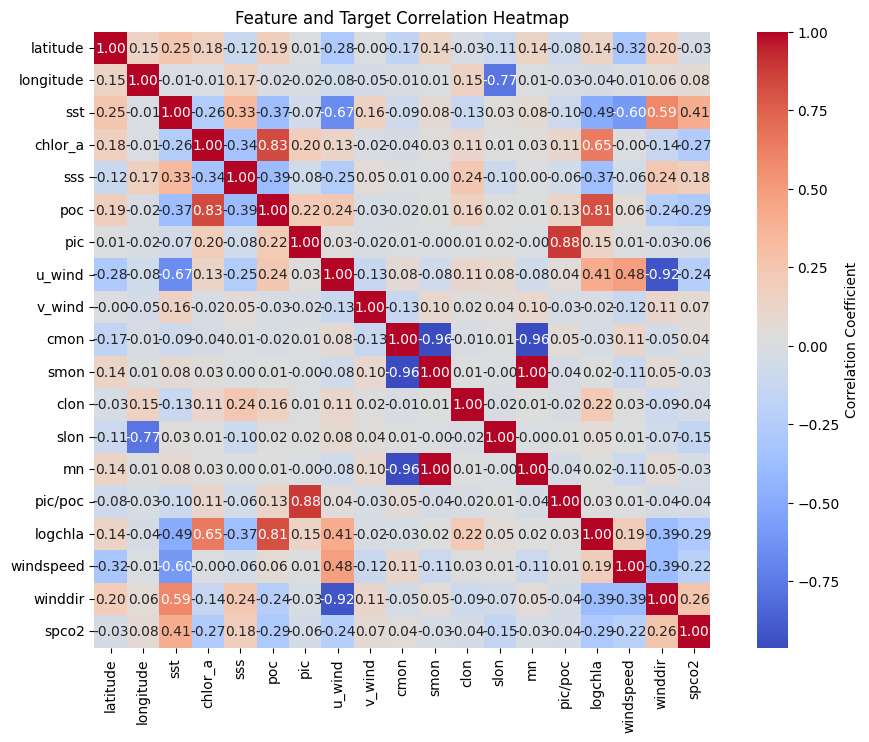

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and targets into a single DataFrame for correlation calculation
data_combined = pd.concat([X, y], axis=1)

# Calculate correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature and Target Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix['spco2']

,spco2
latitude,-0.034476
longitude,0.076600
sst,0.407059
chlor_a,-0.267137
sss,0.184210
poc,-0.287071
pic,-0.056803
u_wind,-0.240846
v_wind,0.071233
cmon,0.036140


In [ ]:
sample_indices = X.sample(frac=0.05, random_state=42).index
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

# Basic Random Forest model for feature selection
rf = RandomForestRegressor(
    n_estimators=100,         # Enough trees for stable feature importance
    max_depth=15,             # Limit depth to avoid overfitting
    max_features='log2',      # Introduces randomness in splits, suitable for regression
    random_state=42,
    n_jobs=-1
)

rf.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=15, max_features='log2', n_jobs=-1,
                      random_state=42)

In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importances)

      feature  importance
0    latitude    0.201328
2         sst    0.195106
1   longitude    0.068915
4         sss    0.065515
3     chlor_a    0.060680
12       slon    0.059031
5         poc    0.058420
11       clon    0.052839
15    logchla    0.049984
16  windspeed    0.036748
13         mn    0.029549
10       smon    0.029454
9        cmon    0.029200
7      u_wind    0.028472
8      v_wind    0.014448
6         pic    0.010251
17    winddir    0.009414
14    pic/poc    0.000645


In [ ]:
from google.colab import runtime
runtime.unassign()

sss, latitude, clon, slon, sst, logchla

In [ ]:
X_train = merged_pco2_df[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y_train = merged_pco2_df['spco2']
X_val = validation[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y_val = validation['spco2']
X_test = test[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y_test = test['spco2']

In [ ]:
!pip install xgboost joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
sample_indices = X_train.sample(frac=0.05, random_state=42).index
X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]

In [ ]:
X_sample.shape

(1962880, 7)

In [ ]:
!pip install geopandas shapely cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00


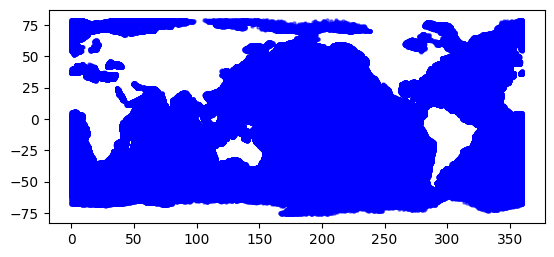

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

latitudes = X_sample['latitude']
longitudes = (np.degrees(np.arctan2(X_sample['slon'], X_sample['clon'])) + 360) % 360

gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(longitudes, latitudes)])

gdf.plot(marker='o', color='blue', markersize=5, alpha=0.5)
plt.show()

In [ ]:
!pip install tqdm

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np

# Define the pipeline and parameter grid
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, verbose=0))
])

param_grid_rf = {
    'rf__n_estimators': [200],
    'rf__max_depth': [20, 30],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [1, 2, 5]
}

# Initialize variables to track the best model and score
best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_rf.set_params(**params)

    # Perform cross-validation and get the mean score
    pipeline_rf.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_rf, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_rf, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_rf

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/12 [00:00<?, ?combination/s]

Training MSE, R2: 
68.25168602417524 0.9342491860258941


Grid Search Progress:   8%|▊         | 1/12 [01:52<20:34, 112.24s/combination, Best MSE=189]

Validation MSE, R2: 
188.64625648886232 0.8319142351132328
Training MSE, R2: 
69.45529445478739 0.9330896801055449


Grid Search Progress:  17%|█▋        | 2/12 [03:43<18:33, 111.38s/combination, Best MSE=189]

Validation MSE, R2: 
188.82806563322225 0.8317522412859397
Training MSE, R2: 
68.33059591178298 0.9341731675471862


Grid Search Progress:  25%|██▌       | 3/12 [05:34<16:41, 111.25s/combination, Best MSE=189]

Validation MSE, R2: 
188.69656845791258 0.8318694066286492
Training MSE, R2: 
69.51251095707036 0.9330345601251165


Grid Search Progress:  33%|███▎      | 4/12 [07:23<14:44, 110.58s/combination, Best MSE=189]

Validation MSE, R2: 
188.8579028674599 0.8317256560017561
Training MSE, R2: 
70.41603586756797 0.9321641420919261


Grid Search Progress:  42%|████▏     | 5/12 [09:12<12:49, 109.94s/combination, Best MSE=189]

Validation MSE, R2: 
189.31704608157978 0.8313165546510358
Training MSE, R2: 
70.41603586756797 0.9321641420919261


Grid Search Progress:  50%|█████     | 6/12 [11:01<10:57, 109.59s/combination, Best MSE=189]

Validation MSE, R2: 
189.3170460815798 0.8313165546510358
Training MSE, R2: 
59.08605866163747 0.9430789673071468


Grid Search Progress:  58%|█████▊    | 7/12 [13:15<09:48, 117.72s/combination, Best MSE=186]

Validation MSE, R2: 
185.52008994501364 0.8346996818242692
Training MSE, R2: 
61.30439380572828 0.9409419161969417


Grid Search Progress:  67%|██████▋   | 8/12 [15:22<08:02, 120.66s/combination, Best MSE=186]

Validation MSE, R2: 
185.59840100211983 0.8346299058627538
Training MSE, R2: 
59.48823848069118 0.9426915241243164


Grid Search Progress:  75%|███████▌  | 9/12 [17:33<06:10, 123.66s/combination, Best MSE=186]

Validation MSE, R2: 
185.71869636108613 0.8345227214542184
Training MSE, R2: 
61.63005112128768 0.9406281915870167


Grid Search Progress:  83%|████████▎ | 10/12 [19:38<04:08, 124.09s/combination, Best MSE=186]

Validation MSE, R2: 
185.80491117059933 0.8344459031675939
Training MSE, R2: 
63.460637211603895 0.938864681665147


Grid Search Progress:  92%|█████████▏| 11/12 [21:39<02:03, 123.14s/combination, Best MSE=186]

Validation MSE, R2: 
186.4460728039181 0.8338746215235355
Training MSE, R2: 
63.46063721160388 0.938864681665147


Grid Search Progress: 100%|██████████| 12/12 [23:39<00:00, 118.31s/combination, Best MSE=186]

Validation MSE, R2: 
186.4460728039181 0.8338746215235355
Best MSE: 
185.52008994501364


In [ ]:
best_params

{'rf__max_depth': 30,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 200}

In [ ]:
best_params = {'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 200,
  'rf__max_samples': 0.2
}

In [ ]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=67, verbose=1))
])
pipeline_rf.set_params(**best_params)
pipeline_rf.fit(X_train, y_train)
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_train, y_train)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_val, y_val)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_test, y_test)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:  4.2min
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed: 10.7min finished
[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   20.8s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   53.0s finished


rf - MSE: 25.4876, R²: 0.9754


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    5.7s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   13.8s finished


rf - MSE: 181.3110, R²: 0.8385


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    5.8s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   13.8s finished


rf - MSE: 310.5087, R²: 0.7364


In [ ]:
!pip install joblib

In [ ]:
import joblib
joblib.dump(pipeline_rf, '/content/drive/MyDrive/STS/rf_pco2.joblib')

KeyboardInterrupt: 

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

best_score = float('-inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_knn.set_params(**params)

    # Perform cross-validation and get the mean score
    scores = cross_val_score(pipeline_knn, X_sample, y_sample, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=3)
    mean_score = np.mean(scores)

    # Update the best model if the current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = pipeline_knn

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': -best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/6 [00:00<?, ?combination/s]

[CV] END ............................. score: (test=-102.703) total time=  25.6s
[CV] END ............................. score: (test=-103.949) total time=  21.4s
[CV] END ............................. score: (test=-102.866) total time=  21.5s
[CV] END ............................. score: (test=-101.711) total time=  17.9s


Grid Search Progress:  17%|█▋        | 1/6 [01:44<08:41, 104.25s/combination, Best MSE=103]

[CV] END ............................. score: (test=-103.137) total time=  17.8s
[CV] END .............................. score: (test=-98.873) total time=  25.3s
[CV] END ............................. score: (test=-100.234) total time=  25.8s
[CV] END .............................. score: (test=-99.256) total time=  26.0s
[CV] END .............................. score: (test=-98.057) total time=  25.8s


Grid Search Progress:  33%|███▎      | 2/6 [03:53<07:54, 118.72s/combination, Best MSE=99.2]

[CV] END .............................. score: (test=-99.538) total time=  25.9s
[CV] END .............................. score: (test=-97.769) total time=  45.3s
[CV] END .............................. score: (test=-98.829) total time=  46.1s
[CV] END .............................. score: (test=-97.736) total time=  19.9s
[CV] END .............................. score: (test=-96.996) total time=  19.9s


Grid Search Progress:  50%|█████     | 3/6 [06:46<07:10, 143.66s/combination, Best MSE=97.9]

[CV] END .............................. score: (test=-97.999) total time=  42.1s
[CV] END .............................. score: (test=-93.083) total time=  42.6s
[CV] END .............................. score: (test=-94.164) total time=  43.0s
[CV] END .............................. score: (test=-93.096) total time=  35.4s
[CV] END .............................. score: (test=-92.340) total time=  35.2s


Grid Search Progress:  67%|██████▋   | 4/6 [09:58<05:25, 162.90s/combination, Best MSE=93.2]

[CV] END .............................. score: (test=-93.450) total time=  36.0s
[CV] END .............................. score: (test=-96.858) total time=  33.7s
[CV] END .............................. score: (test=-97.625) total time=  33.6s
[CV] END .............................. score: (test=-96.886) total time=  25.0s
[CV] END .............................. score: (test=-96.409) total time=  25.1s


Grid Search Progress:  83%|████████▎ | 5/6 [12:21<02:35, 155.47s/combination, Best MSE=93.2]

[CV] END .............................. score: (test=-97.067) total time=  24.8s
[CV] END .............................. score: (test=-91.688) total time=  39.3s
[CV] END .............................. score: (test=-92.491) total time=  44.9s
[CV] END .............................. score: (test=-91.777) total time=  44.4s
[CV] END .............................. score: (test=-91.224) total time=  44.8s


Grid Search Progress: 100%|██████████| 6/6 [15:59<00:00, 159.96s/combination, Best MSE=91.8]

[CV] END .............................. score: (test=-92.064) total time=  45.1s
Best MSE: 
-91.84875294653673


In [ ]:
best_params = {'knn__n_neighbors': 7, 'knn__weights': 'distance'}

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])
pipeline_knn.set_params(**best_params)
pipeline_knn.fit(X_train, y_train)
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_train, y_train)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_val, y_val)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_test, y_test)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")

knn - MSE: 0.0000, R²: 1.0000
knn - MSE: 217.7153, R²: 0.8060
knn - MSE: 349.8178, R²: 0.7030


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/knn_pco2.joblib')

In [ ]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Evaluate
mse_lr, r2_lr = evaluate_model(pipeline_lr, X_test, y_test)
print(f"Linear Regression - MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

Linear Regression - MSE: 797.0404, R²: 0.2408


In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'xgb__n_estimators': [200],             # Number of boosting rounds
    'xgb__max_depth': [3, 6, 9],                    # Maximum depth of a tree
    'xgb__learning_rate': [0.05, 0.1],           # Step size shrinkage
    'xgb__subsample': [0.8],                # Fraction of samples for each boosting round
    'xgb__colsample_bytree': [0.8, 1.0],         # Fraction of features used per tree
    'xgb__min_child_weight': [1, 5],             # Minimum sum of instance weight for leaf nodes
    'xgb__gamma': [0, 0.1],                      # Minimum loss reduction for partitioning
}

best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_xgb))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_xgb.set_params(**params)

    pipeline_xgb.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_xgb, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_xgb, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_xgb

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")

Grid Search Progress:   0%|          | 0/48 [00:00<?, ?combination/s]

Training MSE, R2: 
309.76294 0.7015871405601501


Grid Search Progress:   2%|▏         | 1/48 [00:12<09:43, 12.41s/combination, Best MSE=429]

Validation MSE, R2: 
429.3976 0.6174023151397705
Training MSE, R2: 
309.76294 0.7015871405601501


Grid Search Progress:   4%|▍         | 2/48 [00:26<10:11, 13.29s/combination, Best MSE=429]

Validation MSE, R2: 
429.3976 0.6174023151397705
Training MSE, R2: 
144.7111 0.8605912923812866


Grid Search Progress:   6%|▋         | 3/48 [00:43<11:09, 14.87s/combination, Best MSE=248]

Validation MSE, R2: 
248.29507 0.7787665128707886
Training MSE, R2: 
145.20451 0.8601159453392029


Grid Search Progress:   8%|▊         | 4/48 [00:58<11:06, 15.14s/combination, Best MSE=248]

Validation MSE, R2: 
248.72078 0.778387188911438
Training MSE, R2: 
94.81346 0.9086605906486511


Grid Search Progress:  10%|█         | 5/48 [01:18<11:59, 16.73s/combination, Best MSE=201]

Validation MSE, R2: 
200.58492 0.8212767839431763
Training MSE, R2: 
94.62504 0.908842146396637


Grid Search Progress:  12%|█▎        | 6/48 [01:42<13:34, 19.38s/combination, Best MSE=200]

Validation MSE, R2: 
200.49107 0.8213604092597961
Training MSE, R2: 
245.54454 0.7634525299072266


Grid Search Progress:  15%|█▍        | 7/48 [01:51<10:57, 16.03s/combination, Best MSE=200]

Validation MSE, R2: 
356.78915 0.6820971965789795
Training MSE, R2: 
245.54454 0.7634525299072266


Grid Search Progress:  17%|█▋        | 8/48 [02:02<09:37, 14.44s/combination, Best MSE=200]

Validation MSE, R2: 
356.78915 0.6820971965789795
Training MSE, R2: 
122.92053 0.8815833926200867


Grid Search Progress:  19%|█▉        | 9/48 [02:19<09:53, 15.21s/combination, Best MSE=200]

Validation MSE, R2: 
225.0736 0.7994571328163147
Training MSE, R2: 
123.84891 0.8806890845298767


Grid Search Progress:  21%|██        | 10/48 [02:36<09:54, 15.65s/combination, Best MSE=200]

Validation MSE, R2: 
226.00278 0.7986292243003845
Training MSE, R2: 
86.740944 0.9164373278617859


Grid Search Progress:  23%|██▎       | 11/48 [02:54<10:10, 16.49s/combination, Best MSE=195]

Validation MSE, R2: 
195.39938 0.8258970975875854
Training MSE, R2: 
86.48808 0.9166809320449829


Grid Search Progress:  25%|██▌       | 12/48 [03:12<10:08, 16.91s/combination, Best MSE=195]

Validation MSE, R2: 
194.64676 0.8265677094459534
Training MSE, R2: 
309.76294 0.7015871405601501


Grid Search Progress:  27%|██▋       | 13/48 [03:21<08:22, 14.36s/combination, Best MSE=195]

Validation MSE, R2: 
429.3976 0.6174023151397705
Training MSE, R2: 
309.76294 0.7015871405601501


Grid Search Progress:  29%|██▉       | 14/48 [03:30<07:13, 12.74s/combination, Best MSE=195]

Validation MSE, R2: 
429.3976 0.6174023151397705
Training MSE, R2: 
144.7111 0.8605912923812866


Grid Search Progress:  31%|███▏      | 15/48 [03:43<07:04, 12.87s/combination, Best MSE=195]

Validation MSE, R2: 
248.29507 0.7787665128707886
Training MSE, R2: 
145.20451 0.8601159453392029


Grid Search Progress:  33%|███▎      | 16/48 [03:56<06:56, 13.03s/combination, Best MSE=195]

Validation MSE, R2: 
248.72078 0.778387188911438
Training MSE, R2: 
94.81346 0.9086605906486511


Grid Search Progress:  35%|███▌      | 17/48 [04:16<07:43, 14.95s/combination, Best MSE=195]

Validation MSE, R2: 
200.58492 0.8212767839431763
Training MSE, R2: 
94.62504 0.908842146396637


Grid Search Progress:  38%|███▊      | 18/48 [04:39<08:44, 17.47s/combination, Best MSE=195]

Validation MSE, R2: 
200.49107 0.8213604092597961
Training MSE, R2: 
245.54454 0.7634525299072266


Grid Search Progress:  40%|███▉      | 19/48 [04:47<07:04, 14.65s/combination, Best MSE=195]

Validation MSE, R2: 
356.78915 0.6820971965789795
Training MSE, R2: 
245.54454 0.7634525299072266


Grid Search Progress:  42%|████▏     | 20/48 [04:55<05:55, 12.71s/combination, Best MSE=195]

Validation MSE, R2: 
356.78915 0.6820971965789795
Training MSE, R2: 
122.92053 0.8815833926200867


Grid Search Progress:  44%|████▍     | 21/48 [05:07<05:34, 12.39s/combination, Best MSE=195]

Validation MSE, R2: 
225.0736 0.7994571328163147
Training MSE, R2: 
123.84891 0.8806890845298767


Grid Search Progress:  46%|████▌     | 22/48 [05:21<05:33, 12.81s/combination, Best MSE=195]

Validation MSE, R2: 
226.00278 0.7986292243003845
Training MSE, R2: 
86.74097 0.9164373278617859


Grid Search Progress:  48%|████▊     | 23/48 [05:38<05:55, 14.21s/combination, Best MSE=195]

Validation MSE, R2: 
195.39937 0.8258971571922302
Training MSE, R2: 
86.59463 0.9165782928466797


Grid Search Progress:  50%|█████     | 24/48 [05:55<05:58, 14.93s/combination, Best MSE=195]

Validation MSE, R2: 
194.68909 0.8265299797058105
Training MSE, R2: 
315.0227 0.6965200901031494


Grid Search Progress:  52%|█████▏    | 25/48 [06:04<05:02, 13.16s/combination, Best MSE=195]

Validation MSE, R2: 
435.1391 0.6122865676879883
Training MSE, R2: 
315.0227 0.6965200901031494


Grid Search Progress:  54%|█████▍    | 26/48 [06:12<04:17, 11.70s/combination, Best MSE=195]

Validation MSE, R2: 
435.1391 0.6122865676879883
Training MSE, R2: 
143.9215 0.8613519668579102


Grid Search Progress:  56%|█████▋    | 27/48 [06:28<04:29, 12.82s/combination, Best MSE=195]

Validation MSE, R2: 
245.92361 0.7808794975280762
Training MSE, R2: 
143.45511 0.861801266670227


Grid Search Progress:  58%|█████▊    | 28/48 [06:44<04:36, 13.82s/combination, Best MSE=195]

Validation MSE, R2: 
245.13538 0.7815818786621094
Training MSE, R2: 
94.38605 0.9090723991394043


Grid Search Progress:  60%|██████    | 29/48 [07:04<04:59, 15.77s/combination, Best MSE=195]

Validation MSE, R2: 
202.0402 0.8199800848960876
Training MSE, R2: 
94.064804 0.9093818664550781


Grid Search Progress:  62%|██████▎   | 30/48 [07:21<04:48, 16.05s/combination, Best MSE=195]

Validation MSE, R2: 
201.54665 0.8204198479652405
Training MSE, R2: 
241.76378 0.7670947313308716


Grid Search Progress:  65%|██████▍   | 31/48 [07:29<03:52, 13.67s/combination, Best MSE=195]

Validation MSE, R2: 
352.39752 0.6860101819038391
Training MSE, R2: 
241.76378 0.7670947313308716


Grid Search Progress:  67%|██████▋   | 32/48 [07:41<03:29, 13.09s/combination, Best MSE=195]

Validation MSE, R2: 
352.39752 0.6860101819038391
Training MSE, R2: 
120.6227 0.8837970495223999


Grid Search Progress:  69%|██████▉   | 33/48 [07:56<03:27, 13.86s/combination, Best MSE=195]

Validation MSE, R2: 
223.09013 0.801224410533905
Training MSE, R2: 
120.80162 0.8836246728897095


Grid Search Progress:  71%|███████   | 34/48 [08:12<03:21, 14.37s/combination, Best MSE=195]

Validation MSE, R2: 
223.08615 0.8012279272079468
Training MSE, R2: 
85.44037 0.9176902770996094


Grid Search Progress:  73%|███████▎  | 35/48 [08:34<03:35, 16.60s/combination, Best MSE=195]

Validation MSE, R2: 
194.90665 0.826336145401001
Training MSE, R2: 
85.698235 0.9174418449401855


Grid Search Progress:  75%|███████▌  | 36/48 [08:50<03:17, 16.48s/combination, Best MSE=195]

Validation MSE, R2: 
195.0245 0.8262311816215515
Training MSE, R2: 
315.0227 0.6965200901031494


Grid Search Progress:  77%|███████▋  | 37/48 [08:58<02:33, 13.96s/combination, Best MSE=195]

Validation MSE, R2: 
435.1391 0.6122865676879883
Training MSE, R2: 
315.0227 0.6965200901031494


Grid Search Progress:  79%|███████▉  | 38/48 [09:07<02:04, 12.44s/combination, Best MSE=195]

Validation MSE, R2: 
435.1391 0.6122865676879883
Training MSE, R2: 
143.9215 0.8613519668579102


Grid Search Progress:  81%|████████▏ | 39/48 [09:24<02:03, 13.74s/combination, Best MSE=195]

Validation MSE, R2: 
245.92361 0.7808794975280762
Training MSE, R2: 
143.45511 0.861801266670227


Grid Search Progress:  83%|████████▎ | 40/48 [09:39<01:55, 14.39s/combination, Best MSE=195]

Validation MSE, R2: 
245.13538 0.7815818786621094
Training MSE, R2: 
94.38606 0.9090723395347595


Grid Search Progress:  85%|████████▌ | 41/48 [09:57<01:48, 15.44s/combination, Best MSE=195]

Validation MSE, R2: 
202.03957 0.8199806809425354
Training MSE, R2: 
94.064804 0.9093818664550781


Grid Search Progress:  88%|████████▊ | 42/48 [10:14<01:35, 15.89s/combination, Best MSE=195]

Validation MSE, R2: 
201.54662 0.8204199075698853
Training MSE, R2: 
241.76378 0.7670947313308716


Grid Search Progress:  90%|████████▉ | 43/48 [10:22<01:07, 13.51s/combination, Best MSE=195]

Validation MSE, R2: 
352.39752 0.6860101819038391
Training MSE, R2: 
241.76378 0.7670947313308716


Grid Search Progress:  92%|█████████▏| 44/48 [10:32<00:49, 12.39s/combination, Best MSE=195]

Validation MSE, R2: 
352.39752 0.6860101819038391
Training MSE, R2: 
120.6227 0.8837970495223999


Grid Search Progress:  94%|█████████▍| 45/48 [10:47<00:39, 13.24s/combination, Best MSE=195]

Validation MSE, R2: 
223.09013 0.801224410533905
Training MSE, R2: 
120.80162 0.8836246728897095


Grid Search Progress:  96%|█████████▌| 46/48 [11:01<00:26, 13.31s/combination, Best MSE=195]

Validation MSE, R2: 
223.08615 0.8012279272079468
Training MSE, R2: 
85.44038 0.9176902770996094


Grid Search Progress:  98%|█████████▊| 47/48 [11:21<00:15, 15.42s/combination, Best MSE=195]

Validation MSE, R2: 
194.90672 0.8263360857963562
Training MSE, R2: 
85.698235 0.9174418449401855


Grid Search Progress: 100%|██████████| 48/48 [11:38<00:00, 14.55s/combination, Best MSE=195]

Validation MSE, R2: 
195.02448 0.8262311816215515
Best MSE: 


In [ ]:
best_params

{'xgb__colsample_bytree': 0.8,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.8}

In [ ]:
pipeline_xgb.set_params(**best_params)
pipeline_xgb.fit(X_train, y_train)
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_train, y_train)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_val, y_val)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_test, y_test)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGB - MSE: 83.7686, R²: 0.9193
XGB - MSE: 192.8558, R²: 0.8282
XGB - MSE: 313.8053, R²: 0.7336


In [ ]:
import joblib
joblib.dump(best_model, '/content/drive/MyDrive/STS/xgb_pco2.joblib')

['/content/drive/MyDrive/STS/xgb_pco2.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_sample = X_sample.to_numpy()
y_sample = y_sample.to_numpy()

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Define a function to build the model with given hyperparameters
def build_model(n_hidden_layers=1, n_neurons=64, activation='relu', optimizer='adam',
                learning_rate=0.001, dropout_rate=0.0, input_shape=None):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))
    # Hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1))  # Assuming regression output
    # Compile model
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = optimizer  # Handle other optimizers as needed
    model.compile(optimizer=opt, loss='mse')
    return model

params = {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 20, 'learning_rate': 0.01, 'n_hidden_layers': 1, 'n_neurons': 64, 'optimizer': 'adam'}
model = build_model(
    n_hidden_layers=params['n_hidden_layers'],
    n_neurons=params['n_neurons'],
    activation=params['activation'],
    optimizer=params['optimizer'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    input_shape=(X_sample.shape[1],)
)
    # Fit the model
history = model.fit(
    X_sample, y_sample,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    verbose=1
)

Epoch 1/20
30670/30670 [==============================] - 34s 1ms/step - loss: 486.9841
Epoch 2/20
30670/30670 [==============================] - 34s 1ms/step - loss: 347.5354
Epoch 3/20
30670/30670 [==============================] - 34s 1ms/step - loss: 334.6977
Epoch 4/20
30670/30670 [==============================] - 34s 1ms/step - loss: 325.3586
Epoch 5/20
30670/30670 [==============================] - 34s 1ms/step - loss: 319.0317
Epoch 6/20
30670/30670 [==============================] - 33s 1ms/step - loss: 316.6198
Epoch 7/20
30670/30670 [==============================] - 33s 1ms/step - loss: 314.1866
Epoch 8/20
30670/30670 [==============================] - 33s 1ms/step - loss: 311.8666
Epoch 9/20
30670/30670 [==============================] - 33s 1ms/step - loss: 308.6691
Epoch 10/20
30670/30670 [==============================] - 33s 1ms/step - loss: 306.1529
Epoch 11/20
30670/30670 [==============================] - 33s 1ms/step - loss: 304.8279
Epoch 12/20
30670/30670 [=====

In [ ]:
y_train_pred = model.predict(X_sample)
mse_train = mean_squared_error(y_sample, y_train_pred)
r2_train = r2_score(y_sample, y_train_pred)
print('Best Model Training MSE:', mse_train)
print('Best Model Training R²:', r2_train)

# Evaluate the best model on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Best Model Validation MSE:', mse_val)
print('Best Model Validation R²:', r2_val)

# Evaluate the best model on test set
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print('Best Model Test MSE:', mse_test)
print('Best Model Test R²:', r2_test)

61340/61340 [==============================] - 52s 845us/step
Best Model Training MSE: 295.98352
Best Model Training R²: 0.714515209197998
333490/333490 [==============================] - 293s 879us/step
Best Model Validation MSE: 436.8035
Best Model Validation R²: 0.6108036041259766
331290/331290 [==============================] - 293s 885us/step
Best Model Test MSE: 580.52014
Best Model Test R²: 0.5071001052856445


In [ ]:
from google.colab import runtime
runtime.unassign()

## in situ Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

def get_socat_preamble_size(filepath):
    headerSize = 0;
    with open(filepath) as SOCAT:
      for preline in SOCAT:
         if 'Expocode' not in preline or 'yr' not in preline:
            headerSize += 1;
         else:
            break;
    return headerSize;

def read_socat_file(filepath):
    headerSize = get_socat_preamble_size(filepath);
    return pd.read_table(filepath, sep='\t', skiprows=headerSize);

In [ ]:
socat = read_socat_file('/content/drive/MyDrive/STS/STSData/SOCATv2024.tsv')

<ipython-input-2-4601dd33f71e>:16: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_table(filepath, sep='\t', skiprows=headerSize);


In [ ]:
socat

,Expocode,version,Source_DOI,QC_Flag,yr,mon,day,hh,mm,ss,...,GVCO2 [umol/mol],xCO2water_equ_dry [umol/mol],xCO2water_SST_dry [umol/mol],pCO2water_equ_wet [uatm],pCO2water_SST_wet [uatm],fCO2water_equ_wet [uatm],fCO2water_SST_wet [uatm],fCO2rec [uatm],fCO2rec_src,fCO2rec_flag
0,69920180814,2020.0N,10.25921/x3tg-3m40,C,2018,8,14,18,55,3.0,...,400.820,NaN,NaN,NaN,478.921,NaN,481.481,477.196,4,2
1,69920180814,2020.0N,10.25921/x3tg-3m40,C,2018,8,14,18,55,13.0,...,400.820,NaN,NaN,NaN,478.513,NaN,481.069,476.791,4,2
2,69920180814,2020.0N,10.25921/x3tg-3m40,C,2018,8,14,18,55,23.0,...,400.820,NaN,NaN,NaN,478.104,NaN,480.659,476.382,4,2
3,69920180814,2020.0N,10.25921/x3tg-3m40,C,2018,8,14,18,55,33.0,...,400.820,NaN,NaN,NaN,477.438,NaN,479.990,475.719,4,2
4,69920180814,2020.0N,10.25921/x3tg-3m40,C,2018,8,14,18,55,43.0,...,400.820,NaN,NaN,NaN,477.182,NaN,479.732,475.464,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38613105,ZZ9920070416,2.0N,NaN,D,2009,9,14,10,50,0.0,...,380.113,365.2,NaN,NaN,361.300,NaN,NaN,359.948,1,2
38613106,ZZ9920070416,2.0N,NaN,D,2009,9,14,11,10,0.0,...,380.113,357.8,NaN,NaN,353.900,NaN,NaN,352.655,1,2
38613107,ZZ9920070416,2.0N,NaN,D,2009,9,14,11,30,0.0,...,380.111,365.5,NaN,NaN,361.600,NaN,NaN,360.206,1,2
38613108,ZZ9920070416,2.0N,NaN,D,2009,9,14,11,50,0.0,...,380.109,363.8,NaN,NaN,361.000,NaN,NaN,358.455,1,2


In [ ]:
socat.columns

Index(['Expocode', 'version', 'Source_DOI', 'QC_Flag', 'yr', 'mon', 'day',
       'hh', 'mm', 'ss', 'longitude [dec.deg.E]', 'latitude [dec.deg.N]',
       'sample_depth [m]', 'sal', 'SST [deg.C]', 'Tequ [deg.C]', 'PPPP [hPa]',
       'Pequ [hPa]', 'WOA_SSS', 'NCEP_SLP [hPa]', 'ETOPO2_depth [m]',
       'dist_to_land [km]', 'GVCO2 [umol/mol]', 'xCO2water_equ_dry [umol/mol]',
       'xCO2water_SST_dry [umol/mol]', 'pCO2water_equ_wet [uatm]',
       'pCO2water_SST_wet [uatm]', 'fCO2water_equ_wet [uatm]',
       'fCO2water_SST_wet [uatm]', 'fCO2rec [uatm]', 'fCO2rec_src',
       'fCO2rec_flag'],
      dtype='object')

In [ ]:
socat = socat[['yr', 'mon', 'longitude [dec.deg.E]', 'latitude [dec.deg.N]', 'pCO2water_SST_wet [uatm]', 'sample_depth [m]', 'SST [deg.C]']]

In [ ]:
socat = socat[(socat['yr'] > 2011) | ((socat['yr'] == 2011) & (socat['mon'] > 9))]
socat['month'] = (socat['yr'] - 2011) * 12 + socat['mon'] - 9
socat['longitude'] = round((socat['longitude [dec.deg.E]']) / 0.25) * 0.25 + 0.125
socat['latitude'] = round((socat['latitude [dec.deg.N]']) / 0.25) * 0.25 + 0.125

In [ ]:
socat = socat.dropna()

In [ ]:
socat

,yr,mon,longitude [dec.deg.E],latitude [dec.deg.N],pCO2water_SST_wet [uatm],sample_depth [m],SST [deg.C],month,longitude,latitude
2195945,2012,3,348.020,42.750,365.600,0.0,13.680,6,348.125,42.875
2195946,2012,3,348.020,42.750,366.100,0.0,13.670,6,348.125,42.875
2195947,2012,3,348.020,42.750,366.100,0.0,13.670,6,348.125,42.875
2195948,2012,3,348.020,42.760,366.000,0.0,13.680,6,348.125,42.875
2195949,2012,3,348.020,42.760,366.300,0.0,13.680,6,348.125,42.875
...,...,...,...,...,...,...,...,...,...,...
34329449,2022,11,17.957,-34.270,378.999,0.0,19.949,134,18.125,-34.125
34329450,2022,11,17.957,-34.270,379.025,0.0,19.950,134,18.125,-34.125
34329451,2022,11,17.957,-34.270,378.792,0.0,19.936,134,18.125,-34.125
34329452,2022,11,17.956,-34.269,378.111,0.0,19.927,134,18.125,-34.125


In [ ]:
socat_processed = socat.loc[socat.groupby(['latitude', 'longitude', 'month'])['sample_depth [m]'].idxmin()]

In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')
socatpco2matchup = pd.merge(socat_processed, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
socatpco2matchup = socatpco2matchup.dropna()

In [ ]:
socatpco2matchup['clon'] = np.cos(np.deg2rad(socatpco2matchup['longitude']))
socatpco2matchup['slon'] = np.sin(np.deg2rad(socatpco2matchup['longitude']))
socatpco2matchup['windspeed'] = np.sqrt(socatpco2matchup['u_wind'] ** 2 + socatpco2matchup['v_wind'] ** 2)
socatpco2matchup['winddir'] = (np.degrees(np.arctan2(socatpco2matchup['u_wind'] + 1e-5, socatpco2matchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
socatpco2matchup

,yr,mon,longitude [dec.deg.E],latitude [dec.deg.N],pCO2water_SST_wet [uatm],sample_depth [m],SST [deg.C],month,longitude,latitude,...,chlor_a,sss,poc,pic,u_wind,v_wind,clon,slon,windspeed,winddir
58,2020,2,351.718,-69.840,272.367,5.0,1.921,101,351.875,-69.625,...,5.248933,33.868240,308.600100,0.000640,-4.644531,6.757835,0.989962,-0.141333,8.2,225.0
60,2020,2,353.518,-69.873,283.766,5.0,0.596,101,353.625,-69.625,...,5.092949,34.028860,295.199700,0.000832,-7.581961,5.210938,0.993816,-0.111035,9.2,225.0
63,2020,1,22.525,-69.379,391.176,5.0,3.083,100,22.625,-69.375,...,0.367503,33.538770,99.799805,0.001328,-5.782121,-0.455063,0.923042,0.384698,5.8,225.0
64,2020,1,22.627,-69.473,382.108,5.0,2.362,100,22.875,-69.375,...,0.417096,33.540460,105.399900,0.001272,-5.592325,0.293081,0.921355,0.388722,5.6,225.0
65,2020,1,22.885,-69.579,372.350,5.0,1.870,100,23.125,-69.375,...,0.396786,33.496803,102.199710,0.001114,-5.598081,-0.146591,0.919650,0.392738,5.6,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33754,2022,8,8.146,78.416,294.321,5.0,8.755,131,8.375,78.625,...,0.955864,35.008224,163.399900,0.000418,1.397623,-5.216000,0.989336,0.145651,5.4,45.0
33756,2022,8,8.401,78.417,296.196,5.0,8.759,131,8.625,78.625,...,0.865005,34.983738,155.600100,0.000492,1.397623,-5.216000,0.988691,0.149967,5.4,45.0
33759,2022,8,8.631,78.416,295.887,5.0,8.705,131,8.875,78.625,...,0.828844,34.956500,153.399900,0.000506,1.397623,-5.216000,0.988027,0.154279,5.4,45.0
33762,2022,8,8.881,78.414,295.888,5.0,8.793,131,9.125,78.625,...,0.913948,34.929290,162.600100,0.000624,1.307294,-5.445271,0.987345,0.158589,5.6,45.0


In [ ]:
import math
socatpco2matchup['pco2_adjusted'] = socatpco2matchup['pCO2water_SST_wet [uatm]'] * np.exp(0.0443 * (socatpco2matchup['sst'] - socatpco2matchup['SST [deg.C]']))

In [ ]:
socatpco2matchup = socatpco2matchup[abs(socatpco2matchup['pco2_adjusted'] - socatpco2matchup['pCO2water_SST_wet [uatm]']) <= 40]

In [ ]:
socatpco2matchup

,yr,mon,longitude [dec.deg.E],latitude [dec.deg.N],pCO2water_SST_wet [uatm],sample_depth [m],SST [deg.C],month,longitude,latitude,...,sss,poc,pic,u_wind,v_wind,clon,slon,windspeed,winddir,pco2_adjusted
58,2020,2,351.718,-69.840,272.367,5.0,1.921,101,351.875,-69.625,...,33.868240,308.60010,0.000640,-4.644531,6.757835,0.989962,-0.141333,8.2,225.0,235.312901
60,2020,2,353.518,-69.873,283.766,5.0,0.596,101,353.625,-69.625,...,34.028860,295.19970,0.000832,-7.581961,5.210938,0.993816,-0.111035,9.2,225.0,275.150207
64,2020,1,22.627,-69.473,382.108,5.0,2.362,100,22.875,-69.375,...,33.540460,105.39990,0.001272,-5.592325,0.293081,0.921355,0.388722,5.6,225.0,345.674192
65,2020,1,22.885,-69.579,372.350,5.0,1.870,100,23.125,-69.375,...,33.496803,102.19971,0.001114,-5.598081,-0.146591,0.919650,0.392738,5.6,225.0,341.837430
66,2020,2,351.704,-69.378,292.623,5.0,2.477,101,351.875,-69.375,...,33.890392,261.00000,0.000568,-6.593009,4.531250,0.989962,-0.141333,8.0,225.0,261.574069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33754,2022,8,8.146,78.416,294.321,5.0,8.755,131,8.375,78.625,...,35.008224,163.39990,0.000418,1.397623,-5.216000,0.989336,0.145651,5.4,45.0,277.173729
33756,2022,8,8.401,78.417,296.196,5.0,8.759,131,8.625,78.625,...,34.983738,155.60010,0.000492,1.397623,-5.216000,0.988691,0.149967,5.4,45.0,278.828305
33759,2022,8,8.631,78.416,295.887,5.0,8.705,131,8.875,78.625,...,34.956500,153.39990,0.000506,1.397623,-5.216000,0.988027,0.154279,5.4,45.0,278.710226
33762,2022,8,8.881,78.414,295.888,5.0,8.793,131,9.125,78.625,...,34.929290,162.60010,0.000624,1.307294,-5.445271,0.987345,0.158589,5.6,45.0,275.665891


In [ ]:
X = socatpco2matchup[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y = socatpco2matchup['pco2_adjusted']

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_pco2.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
evaluate_model(model, X, y)
# evaluate_model(pipeline_rf, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(1173.1035436442949, 0.5411980877234108, -12.395037630307717)

In [ ]:
y_pred = model.predict(X)
# y_pred = pipeline_rf.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


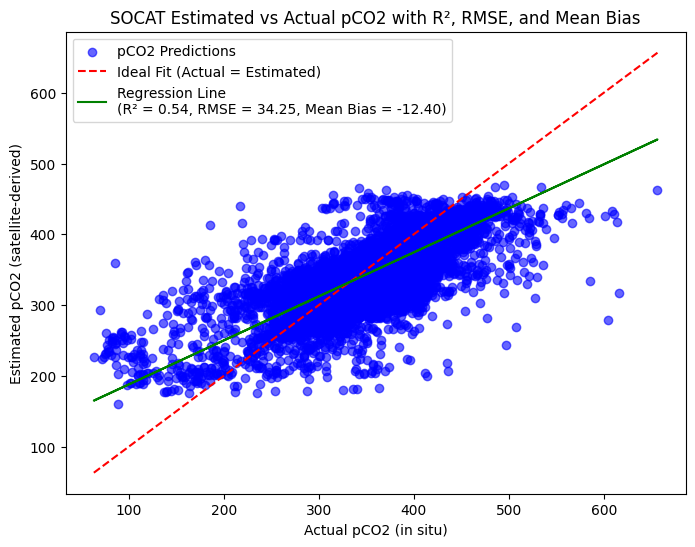

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='pCO2 Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})')

# Labels and title
plt.xlabel('Actual pCO2 (in situ)')
plt.ylabel('Estimated pCO2 (satellite-derived)')
plt.title('SOCAT Estimated vs Actual pCO2 with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

In [ ]:
ldeo = pd.read_csv('/content/drive/MyDrive/STS/STSData/LDEO_Database_V2019.csv')

<ipython-input-59-2b493bfc5cb3>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ldeo = pd.read_csv('/content/drive/MyDrive/STS/STSData/LDEO_Database_V2019.csv')


In [ ]:
ldeo

,FILENAME,STN,LAT,LON,MONTH/DAY/YEAR,JDATE,VCO2_SW,TEMP_PCO2,TEMP,SAL,PCO2_SST,PCO2_SSTPA,PCO2_TEQ,EQ_PBARO,SHIPPBARO
0,0002,1,-58.823,-60.967,4/9/2000,100.24912,364.84,3.30,0.00,33.50,309.35,31.345,356.70,998.3,998.3
1,0002,2,-58.829,-60.962,4/9/2000,100.25045,364.21,3.25,2.56,33.50,345.68,35.026,356.10,998.2,998.2
2,0002,3,-58.834,-60.956,4/9/2000,100.25173,364.61,3.27,2.56,33.47,345.77,35.035,356.50,998.3,998.3
3,0002,4,-58.839,-60.950,4/9/2000,100.25302,365.01,3.33,2.63,33.45,346.21,35.080,356.80,998.0,998.0
4,0002,5,-58.844,-60.944,4/9/2000,100.25430,365.32,3.33,2.63,33.44,346.50,35.109,357.10,998.2,998.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14177821,XL10,5769,50.047,157.432,9/5/2010,248.99306,267.94,10.54,9.76,32.50,254.50,25.787,263.06,1007.3,1007.3
14177822,XL10,5770,50.040,157.424,9/5/2010,248.99514,267.33,10.52,9.75,32.50,254.08,25.745,262.52,1007.5,1007.5
14177823,XL10,5771,50.032,157.416,9/5/2010,248.99653,266.65,10.50,9.72,32.50,253.37,25.673,261.89,1007.6,1007.6
14177824,XL10,5772,50.025,157.407,9/5/2010,248.99792,265.62,10.47,9.71,32.50,252.53,25.588,260.80,1007.3,1007.3


In [ ]:
ldeo['MONTH/DAY/YEAR'].dtype

dtype('O')

In [ ]:
ldeo = ldeo[['MONTH/DAY/YEAR', 'LON', 'LAT', 'PCO2_SST', 'TEMP', 'SHIPPBARO']]
ldeo[['month', 'day', 'yr']] = ldeo['MONTH/DAY/YEAR'].str.split('/', expand=True)

# Drop the 'day' column if only month and year are needed
ldeo = ldeo.drop(columns=['day'])

# Convert 'month' and 'year' columns to integer types, if desired
ldeo['month'] = ldeo['month'].astype(int)
ldeo['yr'] = ldeo['yr'].astype(int)

<ipython-input-62-e9c344786f85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldeo[['month', 'day', 'yr']] = ldeo['MONTH/DAY/YEAR'].str.split('/', expand=True)
<ipython-input-62-e9c344786f85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldeo[['month', 'day', 'yr']] = ldeo['MONTH/DAY/YEAR'].str.split('/', expand=True)
<ipython-input-62-e9c344786f85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [ ]:
ldeo = ldeo[(ldeo['yr'] > 2011) | ((ldeo['yr'] == 2011) & (ldeo['month'] > 9))]
ldeo['month'] = (ldeo['yr'] - 2011) * 12 + ldeo['month'] - 9
ldeo['longitude'] = round((ldeo['LON']) / 0.25) * 0.25 + 0.125
ldeo['latitude'] = round((ldeo['LAT']) / 0.25) * 0.25 + 0.125

<ipython-input-63-c4e56f2b14e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldeo['month'] = (ldeo['yr'] - 2011) * 12 + ldeo['month'] - 9


In [ ]:
ldeo = ldeo.dropna()

In [ ]:
ldeo

,MONTH/DAY/YEAR,LON,LAT,PCO2_SST,TEMP,SHIPPBARO,month,yr,longitude,latitude
900654,10/1/2011,-27.155,-56.939,377.51,-1.76,948.6,1,2011,-27.125,-56.875
900655,10/1/2011,-27.146,-56.941,378.10,-1.75,948.5,1,2011,-27.125,-56.875
900656,10/1/2011,-27.132,-56.945,378.78,-1.75,948.5,1,2011,-27.125,-56.875
900657,10/1/2011,-27.123,-56.947,379.14,-1.75,948.5,1,2011,-26.875,-56.875
900658,10/1/2011,-27.108,-56.951,378.91,-1.74,948.4,1,2011,-26.875,-56.875
...,...,...,...,...,...,...,...,...,...,...
14110037,5/3/2018,-81.124,24.692,270.26,26.64,1014.5,80,2018,-80.875,24.875
14110038,5/3/2018,-81.124,24.692,271.51,26.65,1014.5,80,2018,-80.875,24.875
14110039,5/3/2018,-81.124,24.692,273.08,26.62,1014.5,80,2018,-80.875,24.875
14110040,5/3/2018,-81.124,24.692,276.11,26.60,1014.6,80,2018,-80.875,24.875


In [ ]:
ldeo_processed = ldeo.groupby(['latitude', 'longitude', 'month'])[['PCO2_SST', 'TEMP']].mean().reset_index()
# ldeo_processed = ldeo.loc[ldeo.groupby(['latitude', 'longitude', 'month'])['SHIPPBARO'].idxmin()]

In [ ]:
ldeo_processed

,latitude,longitude,month,PCO2_SST,TEMP
0,-78.625,-163.375,76,177.224667,-0.473333
1,-78.375,-164.875,76,157.633333,-0.243333
2,-78.375,-164.625,18,336.789600,-1.816000
3,-78.375,-164.625,76,158.170000,-0.260000
4,-78.375,-164.125,76,244.102500,-1.222500
...,...,...,...,...,...
202181,90.125,129.875,35,342.420000,-1.687000
202182,90.125,138.125,48,331.520000,-1.480000
202183,90.125,141.875,48,335.250000,-1.470000
202184,90.125,143.375,48,333.920000,-1.470000


In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')
ldeopco2matchup = pd.merge(ldeo_processed, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
ldeopco2matchup = ldeopco2matchup.dropna()

In [ ]:
ldeopco2matchup['clon'] = np.cos(np.deg2rad(ldeopco2matchup['longitude']))
ldeopco2matchup['slon'] = np.sin(np.deg2rad(ldeopco2matchup['longitude']))
ldeopco2matchup['windspeed'] = np.sqrt(ldeopco2matchup['u_wind'] ** 2 + ldeopco2matchup['v_wind'] ** 2)
ldeopco2matchup['winddir'] = (np.degrees(np.arctan2(ldeopco2matchup['u_wind'] + 1e-5, ldeopco2matchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
ldeopco2matchup

,latitude,longitude,month,PCO2_SST,TEMP,sst,chlor_a,sss,poc,pic,u_wind,v_wind,clon,slon,windspeed,winddir
17,-77.625,176.875,64,291.265000,-0.830000,-0.245,0.107306,34.555340,70.399900,0.001442,2.545584,2.545584,-0.998513,0.054515,3.6,45.0
19,-77.625,177.125,64,288.148571,-0.691429,-0.380,0.167592,34.508484,77.000000,0.001178,1.906760,3.742227,-0.998741,0.050157,4.2,45.0
22,-77.625,177.625,27,340.266765,-1.093971,-1.265,0.250463,34.262430,69.799805,0.000394,3.479479,3.864353,-0.999141,0.041440,5.2,45.0
24,-77.625,177.875,64,274.597500,-0.692500,-0.110,0.193281,34.360510,78.000000,0.000974,-0.522642,4.972609,-0.999312,0.037080,5.0,225.0
26,-77.625,178.125,64,267.108462,-0.616154,-0.315,0.219980,34.310356,80.799805,0.000904,-1.952336,4.385018,-0.999465,0.032719,4.8,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48229,80.125,7.875,45,229.057037,4.794926,4.535,0.601459,35.162120,117.799805,0.000324,-4.567727,-2.033683,0.990569,0.137012,5.0,225.0
48231,80.125,8.125,45,224.838750,3.909750,4.685,0.651573,35.152170,122.399900,0.000290,-2.611348,2.478076,0.989962,0.141333,3.6,225.0
48233,80.125,8.375,45,221.403636,4.556159,4.580,0.601734,35.141483,117.799805,0.000268,-2.611348,2.478076,0.989336,0.145651,3.6,225.0
48234,80.125,8.625,45,225.843636,5.223364,4.665,0.593038,35.130283,116.799805,0.000232,-0.619601,3.343067,0.988691,0.149967,3.4,225.0


In [ ]:
import math
ldeopco2matchup['pco2_adjusted'] = ldeopco2matchup['PCO2_SST'] * np.exp(0.0443 * (ldeopco2matchup['sst'] - ldeopco2matchup['TEMP']))

In [ ]:
ldeopco2matchup = ldeopco2matchup[abs(ldeopco2matchup['pco2_adjusted'] - ldeopco2matchup['PCO2_SST']) <= 40]

In [ ]:
ldeopco2matchup

,latitude,longitude,month,PCO2_SST,TEMP,sst,chlor_a,sss,poc,pic,u_wind,v_wind,clon,slon,windspeed,winddir,pco2_adjusted
17,-77.625,176.875,64,291.265000,-0.830000,-0.245,0.107306,34.555340,70.399900,0.001442,2.545584,2.545584,-0.998513,0.054515,3.6,45.0,298.911937
19,-77.625,177.125,64,288.148571,-0.691429,-0.380,0.167592,34.508484,77.000000,0.001178,1.906760,3.742227,-0.998741,0.050157,4.2,45.0,292.151501
22,-77.625,177.625,27,340.266765,-1.093971,-1.265,0.250463,34.262430,69.799805,0.000394,3.479479,3.864353,-0.999141,0.041440,5.2,45.0,337.698440
24,-77.625,177.875,64,274.597500,-0.692500,-0.110,0.193281,34.360510,78.000000,0.000974,-0.522642,4.972609,-0.999312,0.037080,5.0,225.0,281.775637
26,-77.625,178.125,64,267.108462,-0.616154,-0.315,0.219980,34.310356,80.799805,0.000904,-1.952336,4.385018,-0.999465,0.032719,4.8,225.0,270.695863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48229,80.125,7.875,45,229.057037,4.794926,4.535,0.601459,35.162120,117.799805,0.000324,-4.567727,-2.033683,0.990569,0.137012,5.0,225.0,226.434637
48231,80.125,8.125,45,224.838750,3.909750,4.685,0.651573,35.152170,122.399900,0.000290,-2.611348,2.478076,0.989962,0.141333,3.6,225.0,232.694644
48233,80.125,8.375,45,221.403636,4.556159,4.580,0.601734,35.141483,117.799805,0.000268,-2.611348,2.478076,0.989336,0.145651,3.6,225.0,221.637596
48234,80.125,8.625,45,225.843636,5.223364,4.665,0.593038,35.130283,116.799805,0.000232,-0.619601,3.343067,0.988691,0.149967,3.4,225.0,220.325804


In [ ]:
X = ldeopco2matchup[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y = ldeopco2matchup['pco2_adjusted']

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_pco2.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
evaluate_model(model, X, y)
# evaluate_model(pipeline_rf, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(346.17092170879647, 0.6985510274713475, 1.957641143755814)

In [ ]:
y_pred = model.predict(X)
# y_pred = pipeline_rf.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


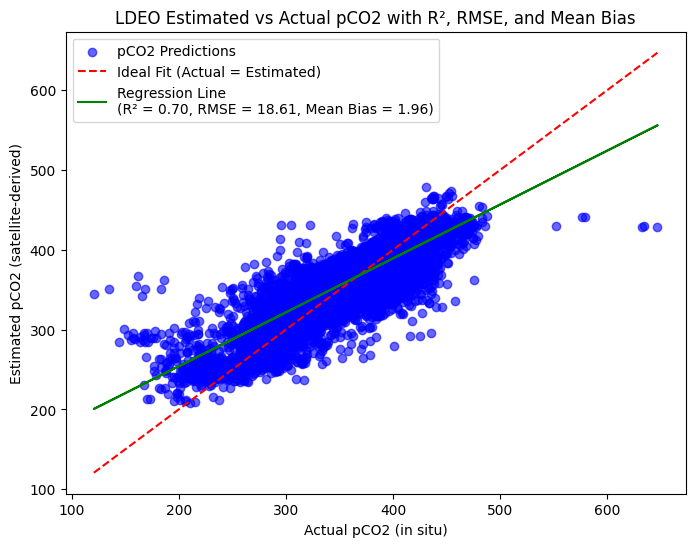

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='pCO2 Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})')

# Labels and title
plt.xlabel('Actual pCO2 (in situ)')
plt.ylabel('Estimated pCO2 (satellite-derived)')
plt.title('LDEO Estimated vs Actual pCO2 with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

## Basin Analysis

In [ ]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/output_basins.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
basins = xr_dataset.to_dataframe().reset_index()

In [ ]:
basins = basins.rename(columns={'lon' : 'longitude', 'lat' : 'latitude'})

In [ ]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y = test[['spco2', 'latitude', 'longitude']]

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_pco2.joblib')

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   19.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   39.3s finished


In [ ]:
y['predictions'] = y_pred

<ipython-input-19-e35c45553dfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return rmse, r2, mean_bias

In [ ]:
def region_accuracy(rgn = -1):
  if rgn != -1:
    merged_df = pd.merge(y, basins, on=['latitude', 'longitude'])
    basin_data = merged_df[merged_df['open_ocean'] == rgn]
  else:
    basin_data = y
  rmse = np.sqrt(mean_squared_error(basin_data['spco2'], basin_data['predictions']))
  r2 = r2_score(basin_data['spco2'], basin_data['predictions'])
  mean_bias = np.mean(basin_data['predictions'] - basin_data['spco2'])
  return rmse, r2, mean_bias, len(basin_data)

In [ ]:
print("RMSE, R2, Bias, n")
print("Atlantic: ", region_accuracy(1))
print("Pacific: ", region_accuracy(2))
print("Indian: ", region_accuracy(3))
print("Arctic: ", region_accuracy(4))
print("Southern: ", region_accuracy(5))
print("Global: ", region_accuracy())

RMSE, R2, Bias, n
Atlantic:  (10.278039565417982, 0.8957750839731153, -4.121823421545016, 12498600)
Pacific:  (11.985346650412769, 0.8926968676444269, -4.567578330225741, 27162876)
Indian:  (9.885349423685234, 0.8352657843681287, -4.23128239648406, 7916982)
Arctic:  (14.442134547803072, 0.8915305995268983, -3.1177698339044047, 917093)
Southern:  (9.884255150725151, 0.7389548366834031, -3.464807100925516, 11791015)
Global:  (11.060202115644651, 0.8902482745354269, -4.189205625480484, 60530524)


## Monthly Analysis

In [ ]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y = test[['spco2', 'month']]

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_pco2.joblib')

In [ ]:
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   19.2s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   39.5s finished
<ipython-input-24-cdc18176f924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [ ]:
def month_accuracy(mn):
  mn = (mn + 4) % 12
  month_data = y[y['month'] % 12 == mn]
  rmse = np.sqrt(mean_squared_error(month_data['spco2'], month_data['predictions']))
  r2 = r2_score(month_data['spco2'], month_data['predictions'])
  mean_bias = np.mean(month_data['predictions'] - month_data['spco2'])
  return rmse, r2, mean_bias, len(month_data)

In [ ]:
print("RMSE, R2, Bias, n")
print("January: ", month_accuracy(0))
print("February: ", month_accuracy(1))
print("March: ", month_accuracy(2))
print("April: ", month_accuracy(3))
print("May: ", month_accuracy(4))
print("June: ", month_accuracy(5))
print("July: ", month_accuracy(6))
print("August: ", month_accuracy(7))
print("September: ", month_accuracy(8))
print("October: ", month_accuracy(9))
print("November: ", month_accuracy(10))
print("December: ", month_accuracy(11))

RMSE, R2, Bias, n
January:  (10.558535089963309, 0.8837838648242555, -3.646903838555515, 5223590)
February:  (10.44571839008821, 0.8901750716601257, -3.9231534389657847, 5357360)
March:  (10.808824591474604, 0.8704196122000141, -4.717867704358412, 5402075)
April:  (11.501286089555371, 0.8507498741022828, -4.404081253716244, 4840527)
May:  (11.847671122947174, 0.8917124511319312, -4.10148510570758, 4432591)
June:  (12.080821524476468, 0.9166327969857634, -4.349905692765558, 4152294)
July:  (11.2270223982036, 0.931312534657271, -4.146878891948823, 4349633)
August:  (11.25550975005408, 0.920524600298138, -5.283510422399118, 4782338)
September:  (10.428848546595372, 0.9070275559744672, -3.7652541731648963, 5584370)
October:  (10.480580716241866, 0.8579825794424324, -3.766675335196494, 5608543)
November:  (10.865788659274292, 0.8283327715931518, -3.900426008794939, 5399982)
December:  (11.573781373038152, 0.836751475387472, -4.435837635411776, 5397221)


In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
satellite_data['mn'] = satellite_data['month'] % 12
satellite_data['cmon'] = np.cos(np.deg2rad(satellite_data['mn']))
satellite_data['smon'] = np.sin(np.deg2rad(satellite_data['mn']))
satellite_data['clon'] = np.cos(np.deg2rad(satellite_data['longitude']))
satellite_data['slon'] = np.sin(np.deg2rad(satellite_data['longitude']))
satellite_data['pic/poc'] = satellite_data['pic']/satellite_data['poc']
satellite_data['logchla'] = np.log(satellite_data['chlor_a'] + 1e-5)
satellite_data['windspeed'] = np.sqrt(satellite_data['u_wind'] ** 2 + satellite_data['v_wind'] ** 2)
satellite_data['winddir'] = (np.degrees(np.arctan2(satellite_data['u_wind'] + 1e-5, satellite_data['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
y = satellite_data[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir', 'month']]
y = y.dropna()
X = y[['latitude', 'sst', 'sss', 'longitude', 'chlor_a', 'windspeed', 'winddir']]
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   20.4s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   41.4s finished


In [ ]:
import xarray as xr
import numpy as np

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

spco2 = ds['spco2']

# Select the specific variable 'spco2' and time indices from 361 to 480
spco2_subset = spco2.isel(time=slice(360, 480))  # Python uses zero-based indexing

# Compute the monthly climatology over the selected 10 years
monthly_climatology = spco2_subset.groupby('time.month').mean(dim='time')

monthly_climatology = monthly_climatology.assign_coords(
    lon=((monthly_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
monthly_climatology = monthly_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the monthly climatologies onto the new grid
interp_spco2 = monthly_climatology.interp(lat=new_lat, lon=new_lon, method='linear')

In [ ]:
ten_year = y[(y['month'] >= 4) & (y['month'] <= 123)]

In [ ]:
def month_clim(mn = -1):
  if(mn != -1):
    mn = (mn + 4) % 12
    month_data = ten_year[ten_year['month'] % 12 == mn]
  else:
    month_data = ten_year
  month_data = month_data.dropna()
  monthly_climatology = month_data.groupby(['latitude', 'longitude'])['predictions'].mean().reset_index()
  return monthly_climatology

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'interp_spco2' is your observed climatology DataArray from previous steps
# And 'month_clim' is your function that returns predicted climatology for a given month

# Initialize lists to store metrics for each month
r2_list = []
rmse_list = []
mean_bias_list = []
n_list = []

for i in range(12):
    # **1. Get Predicted Climatology for Month i**
    # Call your function 'month_clim' to get the predicted climatology for month i
    pred_clim = month_clim(i)  # Should return a pandas DataFrame

    # Ensure 'pred_clim' has columns 'lat', 'lon', 'spco2_pred'
    if 'predictions' in pred_clim.columns:
        pred_clim = pred_clim.rename(columns={'predictions': 'spco2_pred'})


    # **3. Get Observed Climatology for Month i+1**
    # 'interp_spco2' uses months from 1 to 12
    observed_clim = interp_spco2.sel(month=i+1)

    # Convert the observed DataArray to a DataFrame
    observed_clim_df = observed_clim.to_dataframe(name='spco2_obs').reset_index().dropna()
    observed_clim_df = observed_clim_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
    observed_clim_df['longitude'] = (observed_clim_df['longitude'] + 360) % 360

    # **4. Merge Predicted and Observed DataFrames on 'lat' and 'lon'**
    merged_df = pd.merge(pred_clim, observed_clim_df, on=['latitude', 'longitude'])

    merged_df = merged_df.dropna()
    # **5. Compute Metrics**
    # R² Score
    r2 = r2_score(merged_df['spco2_obs'], merged_df['spco2_pred'])

    # Root Mean Squared Error (rmse)
    rmse = np.sqrt(mean_squared_error(merged_df['spco2_obs'], merged_df['spco2_pred']))

    # Mean Bias (Mean of Differences)
    mean_bias = np.mean(merged_df['spco2_pred'] - merged_df['spco2_obs'])

    n = len(merged_df)

    # print(r2, rmse, mean_bias, n)
    # **6. Store Metrics**
    r2_list.append(r2)
    rmse_list.append(rmse)
    mean_bias_list.append(mean_bias)
    n_list.append(n)

# **7. Compile Results into a DataFrame**
metrics_df = pd.DataFrame({
    'Month': range(1, 13),
    'R²': r2_list,
    'rmse': rmse_list,
    'Mean Bias': mean_bias_list,
    'n': n_list
})

# **8. Display the Results**
print(metrics_df)

    Month        R²       rmse  Mean Bias       n
0       1  0.918678   8.134438  -2.179484  513075
1       2  0.917315   8.511645  -3.277499  530506
2       3  0.893402   8.857336  -3.700325  531526
3       4  0.871496   9.574492  -2.862097  492427
4       5  0.883078  11.244453  -2.561493  436629
5       6  0.904139  11.870774  -3.548607  415076
6       7  0.910838  12.169136  -3.395266  439363
7       8  0.909677  11.794639  -2.299854  487870
8       9  0.902104  10.340423  -2.856809  509856
9      10  0.889482   8.765276  -2.223606  489622
10     11  0.880161   8.266457  -2.225813  478114
11     12  0.872360   9.000703  -3.216153  489751


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

# Select the specific variable 'spco2' and time indices from 361 to 480
spco2_subset = ds['spco2'].isel(time=slice(360, 480))  # Zero-based indexing

# Compute the full climatology over the selected 10-year period
full_climatology = spco2_subset.mean(dim='time')

full_climatology = full_climatology.assign_coords(
    lon=((full_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
full_climatology = full_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the full climatology onto the new grid
interp_full_climatology = full_climatology.interp(lat=new_lat, lon=new_lon)

# Convert to DataFrame
full_climatology_df = interp_full_climatology.to_dataframe(name='spco2_obs').reset_index().dropna()
full_climatology_df = full_climatology_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
# full_climatology_df['longitude'] = (full_climatology_df['longitude'] + 360) % 360

In [ ]:
full_climatology_df.max()

,0
latitude,85.375000
longitude,359.375000
spco2_obs,496.023741


In [ ]:
pred_clim = month_clim()
merged_df = pd.merge(pred_clim, full_climatology_df, on=['latitude', 'longitude']).dropna()
merged_df['pCO2 Differences With GRACER'] = merged_df['predictions'] - merged_df['spco2_obs']

In [ ]:
ds = merged_df.set_index(['latitude', 'longitude']).to_xarray()
ds.to_netcdf('climatological_diff.nc')

In [ ]:
merged_df.min()

,0
latitude,-74.375000
longitude,0.625000
predictions,186.351062
spco2_obs,257.348733
pCO2 Differences With GRACER,-170.167890
